=== Iniciando Análisis Comparativo de Rendimiento JADE vs SPADE ===
Cargando datos desde Perfmon\JADE-SMALL\Procesos_223225033224.csv...


C:\Users\fccod\AppData\Local\Temp\ipykernel_28176\37646072.py:96: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['DateTimeIndex'] = timestamps


Se extrajeron timestamps con éxito.
Agregada columna 'ElapsedTime' en segundos.
Cargando datos desde Perfmon\JADE-MEDIUM\Procesos_223325033309.csv...


C:\Users\fccod\AppData\Local\Temp\ipykernel_28176\37646072.py:96: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['DateTimeIndex'] = timestamps


Se extrajeron timestamps con éxito.
Agregada columna 'ElapsedTime' en segundos.
Cargando datos desde Perfmon\JADE-FULL\Procesos_223325033351.csv...


C:\Users\fccod\AppData\Local\Temp\ipykernel_28176\37646072.py:96: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['DateTimeIndex'] = timestamps


Se extrajeron timestamps con éxito.
Agregada columna 'ElapsedTime' en segundos.
Cargando datos desde Perfmon\SPADE-SMALL\Procesos_223825033831.csv...


C:\Users\fccod\AppData\Local\Temp\ipykernel_28176\37646072.py:96: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['DateTimeIndex'] = timestamps


Se extrajeron timestamps con éxito.
Agregada columna 'ElapsedTime' en segundos.
Cargando datos desde Perfmon\SPADE-MEDIUM\Procesos_223925033916.csv...


C:\Users\fccod\AppData\Local\Temp\ipykernel_28176\37646072.py:96: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['DateTimeIndex'] = timestamps


Se extrajeron timestamps con éxito.
Agregada columna 'ElapsedTime' en segundos.
Cargando datos desde Perfmon\SPADE-FULL\Procesos_224025034011.csv...


C:\Users\fccod\AppData\Local\Temp\ipykernel_28176\37646072.py:96: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['DateTimeIndex'] = timestamps


Se extrajeron timestamps con éxito.
Agregada columna 'ElapsedTime' en segundos.

=== Generando Visualizaciones Comparativas ===


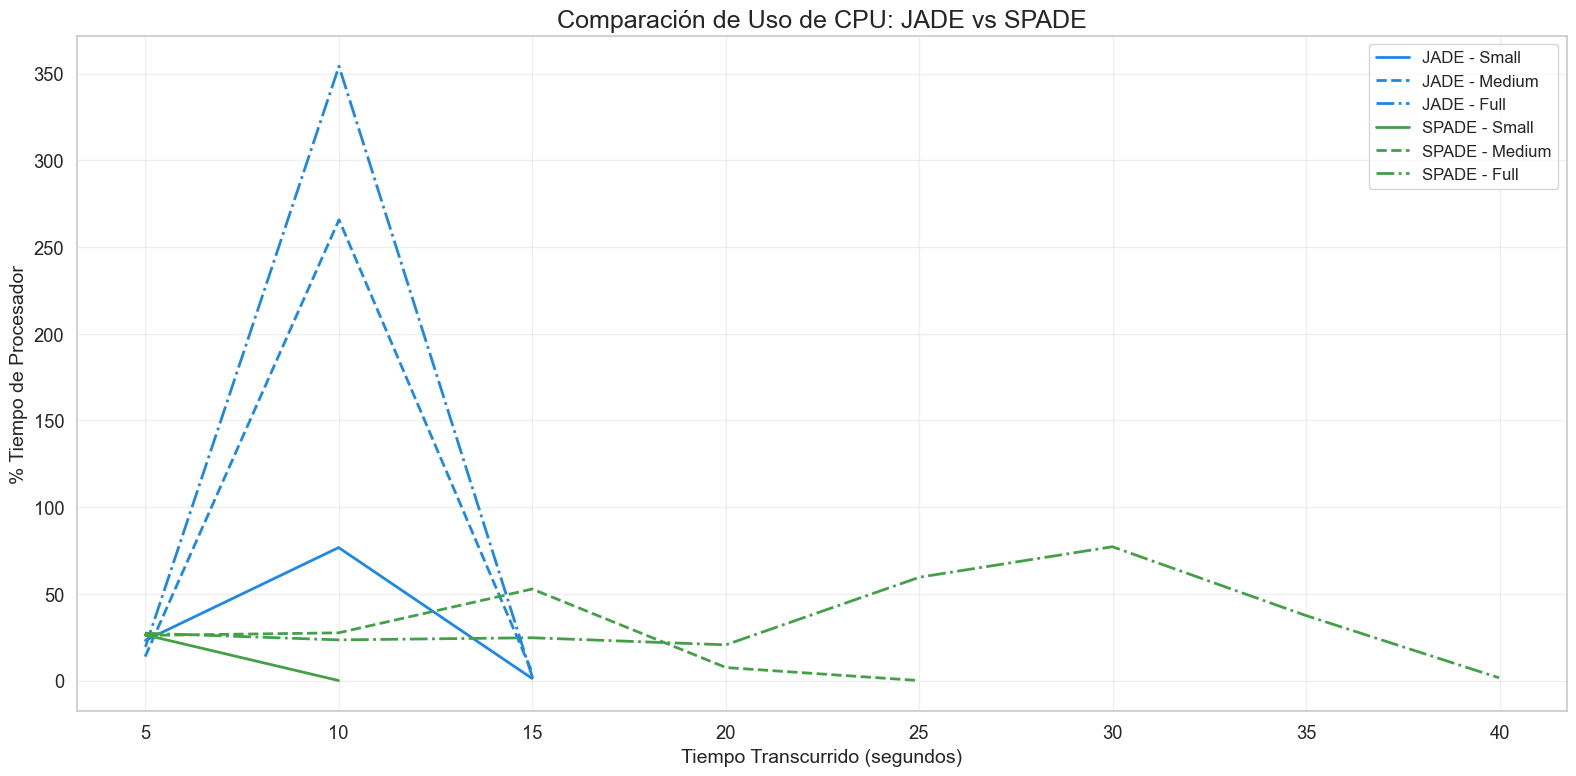

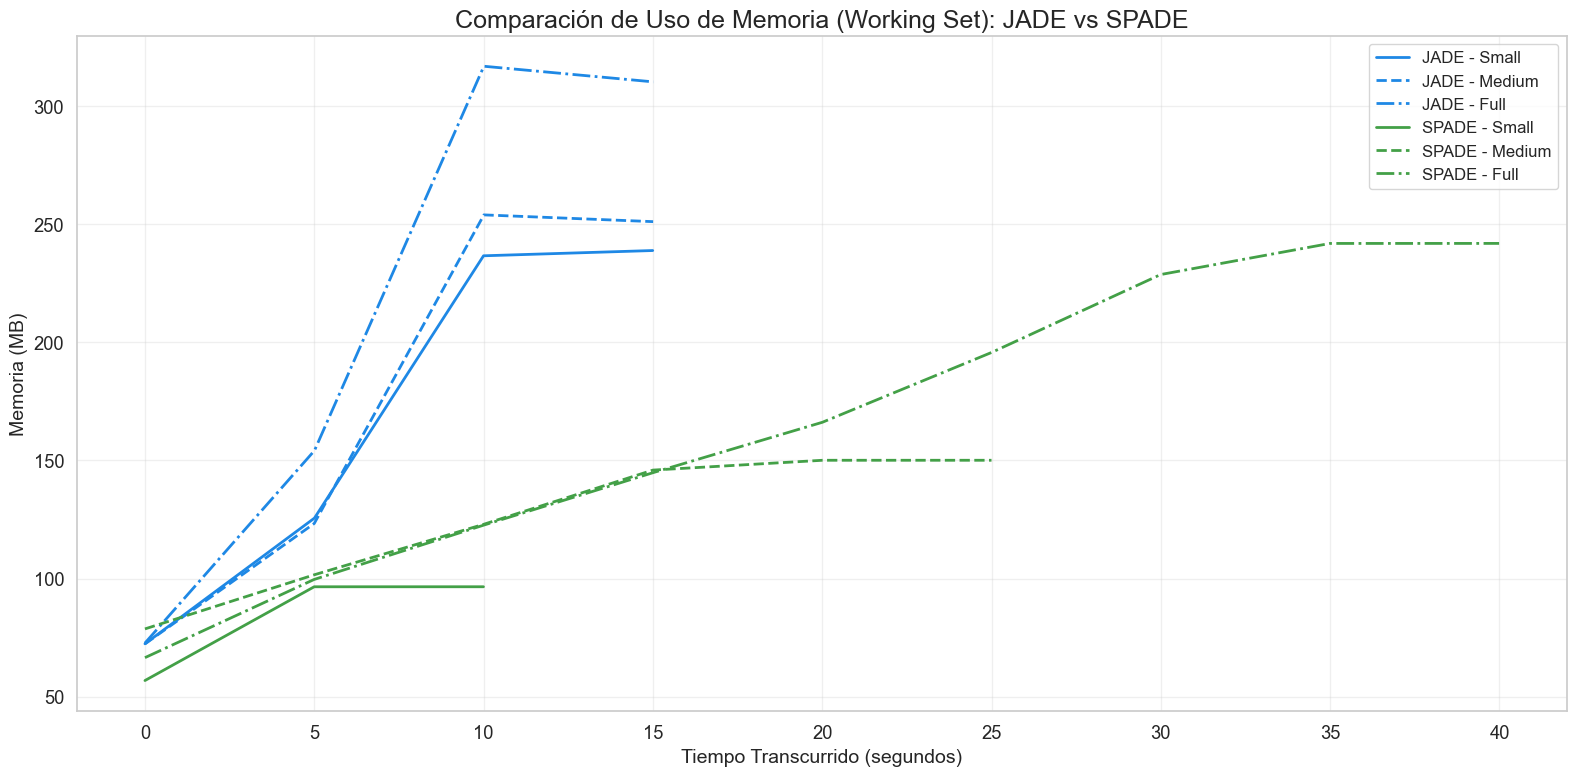

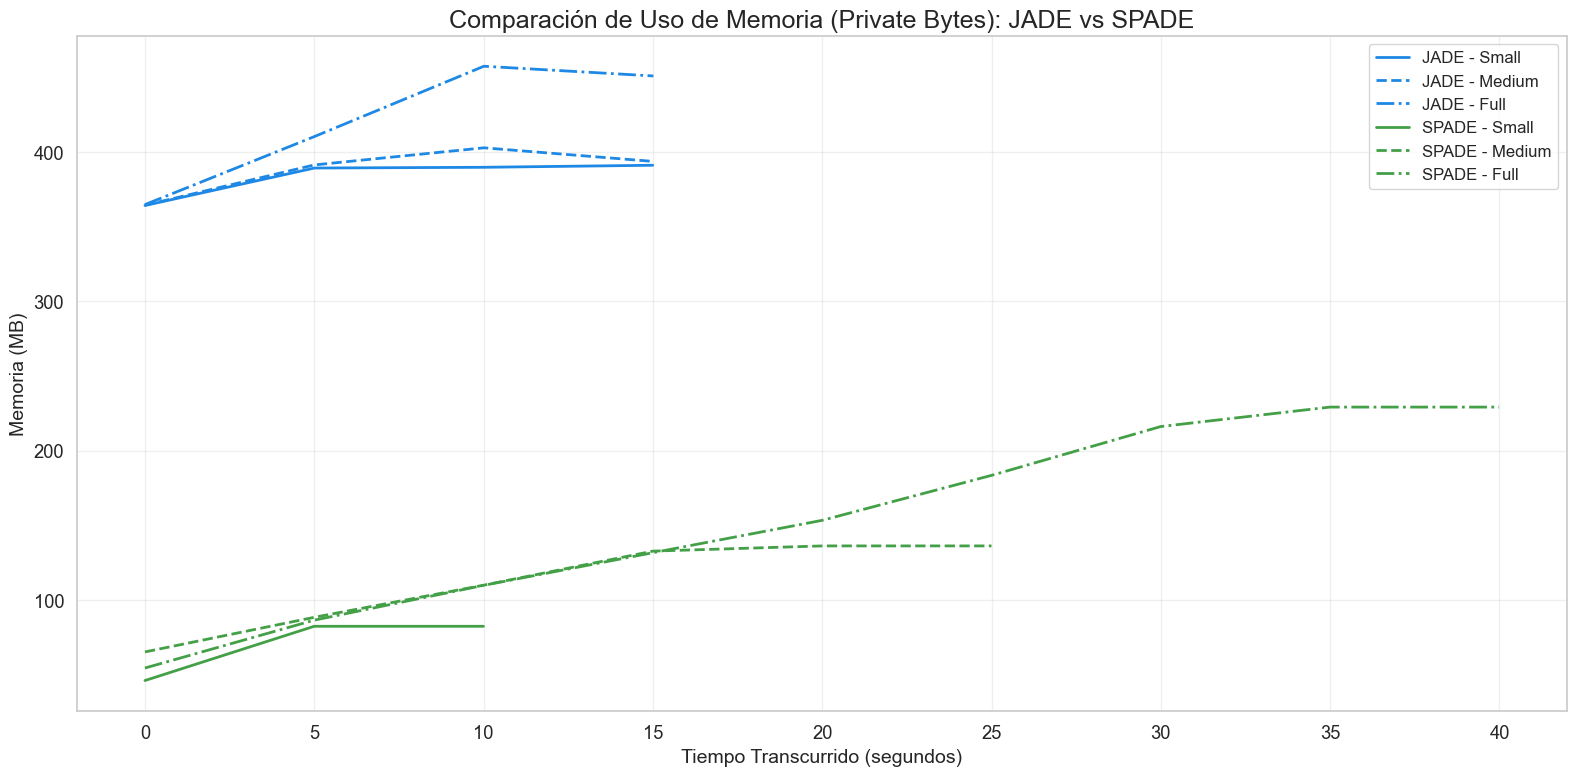

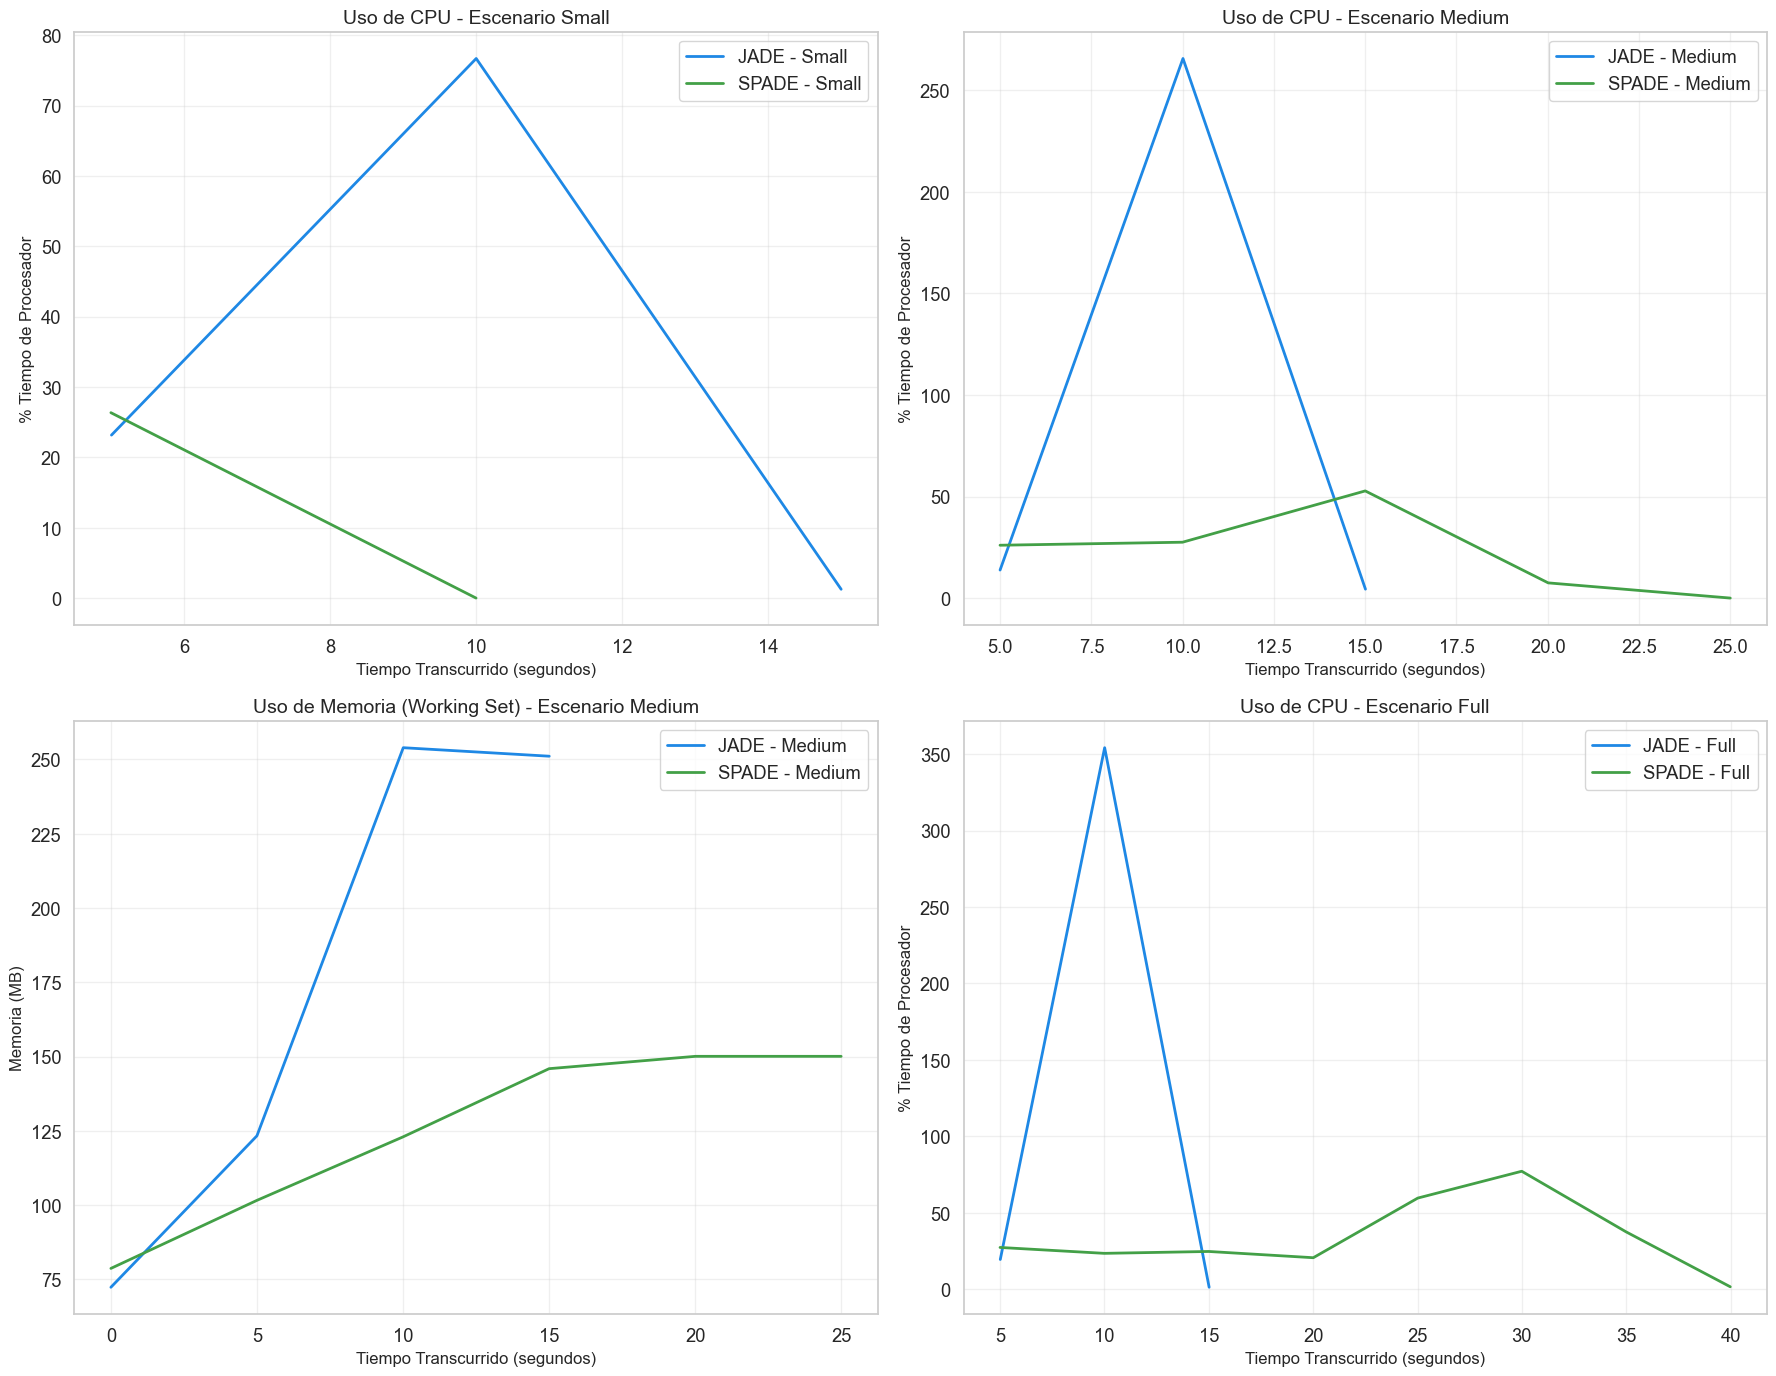


=== Calculando Métricas de Rendimiento ===

Resumen de Métricas de Rendimiento:
  Platform Scenario  CPU_Avg (%)  CPU_Max (%)  CPU_StdDev  \
0     JADE    Small    33.697154    76.679398   38.802318   
1     JADE   Medium    94.628880   265.714108  148.238964   
2     JADE     Full   124.967718   354.239560  198.762916   
3    SPADE    Small    13.173518    26.347037   18.630168   
4    SPADE   Medium    22.757032    52.770783   20.525397   
5    SPADE     Full    33.978299    77.152693   23.919975   

   Mem_Private_Avg (MB)  Mem_Private_Max (MB)  Mem_WorkingSet_Avg (MB)  \
0            383.475586            391.015625               168.361328   
1            387.939453            402.703125               175.164062   
2            420.764648            457.316406               213.495117   
3             70.196615             82.304688                83.274740   
4            111.356771            136.128906               124.865885   
5            154.771267            229.085938  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from datetime import datetime
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker

# Configuración de estilo para las gráficas
plt.style.use('ggplot')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

# Definir las rutas de los archivos CSV (deberás ajustar estas rutas a tu estructura de archivos)
# Esta es una estructura de ejemplo, ajusta según tu organización de archivos
data_files = {
    'JADE': {
        'Small': 'Perfmon\JADE-SMALL\Procesos_223225033224.csv',  # PID: 40492
        'Medium': 'Perfmon\JADE-MEDIUM\Procesos_223325033309.csv',  # PID: 40428
        'Full': 'Perfmon\JADE-FULL\Procesos_223325033351.csv'      # PID: 15476
    },
    'SPADE': {
        'Small': 'Perfmon\SPADE-SMALL\Procesos_223825033831.csv',  # PID: 49140
        'Medium': 'Perfmon\SPADE-MEDIUM\Procesos_223925033916.csv', # PID: 46696
        'Full': 'Perfmon\SPADE-FULL\Procesos_224025034011.csv'     # PID: 6284
    }
}

# PIDs para cada plataforma y escenario
pids = {
    'JADE': {
        'Small': 27052,
        'Medium': 23388,
        'Full': 18592
    },
    'SPADE': {
        'Small': 34940,
        'Medium': 34504,
        'Full': 34876
    }
}

# Función para cargar y preprocesar datos de Perfmon
def load_perfmon_data(filepath):
    """Carga y preprocesa un archivo CSV de Perfmon"""
    print(f"Cargando datos desde {filepath}...")
    
    try:
        # Leer el CSV
        df = pd.read_csv(filepath)
        
        # Renombrar la primera columna a 'Timestamp'
        if len(df.columns) > 0:
            df = df.rename(columns={df.columns[0]: 'Timestamp'})
        else:
            print(f"Error: El archivo {filepath} no tiene columnas.")
            return None
        
        for col in df.columns:
            if col != 'Timestamp':  # No intentar convertir la columna de timestamp
                try:
                    # Reemplazar comas y eliminar unidades si es necesario
                    df[col] = df[col].astype(str)
                    df[col] = df[col].str.replace(',', '')
                    df[col] = df[col].str.replace(' KB', '')
                    df[col] = df[col].str.replace(' MB', '')
                    df[col] = df[col].str.replace(' %', '')
                    
                    # Convertir a numérico, con errores como NaN
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                except Exception as e:
                    print(f"Advertencia: No se pudo convertir la columna {col} a numérico: {e}")
        
        # Intentar extraer timestamps de la primera columna
        try:
            # Buscar patrones como MM/DD/YYYY HH:MM:SS.mmm en los datos
            date_pattern = r'(\d{1,4}[-/]\d{1,2}[-/]\d{1,4}\s\d{1,2}:\d{2}:\d{2}(?:\.\d+)?)'
            
            # Extraer timestamps si coinciden con el patrón
            timestamps = []
            for time_str in df['Timestamp']:
                match = re.search(date_pattern, str(time_str))
                if match:
                    try:
                        timestamp = pd.to_datetime(match.group(1))
                        timestamps.append(timestamp)
                    except:
                        timestamps.append(pd.NaT)
                else:
                    timestamps.append(pd.NaT)
                    
            # Si tenemos timestamps válidos, usarlos
            if not all(pd.isna(timestamps)):
                df['DateTimeIndex'] = timestamps
                df = df[~pd.isna(df['DateTimeIndex'])]
                print(f"Se extrajeron timestamps con éxito.")
            else:
                print("No se pudieron extraer timestamps de la primera columna. Usando secuencia numérica.")
                df['DateTimeIndex'] = pd.date_range(start=datetime.now(), periods=len(df), freq='S')
        except Exception as e:
            print(f"Error al procesar timestamps: {e}")
            print("Usando secuencia numérica con timestamps artificiales.")
            df['DateTimeIndex'] = pd.date_range(start=datetime.now(), periods=len(df), freq='S')
        
        # Calcular tiempo transcurrido en segundos desde el primer timestamp
        if 'DateTimeIndex' in df.columns:
            start_time = df['DateTimeIndex'].min()
            df['ElapsedTime'] = (df['DateTimeIndex'] - start_time).dt.total_seconds()
            print("Agregada columna 'ElapsedTime' en segundos.")
        else:
            print("Warning: No se pudo crear la columna 'DateTimeIndex'. Creando 'ElapsedTime' como secuencia simple.")
            df['ElapsedTime'] = range(len(df))
        
        return df
    
    except Exception as e:
        print(f"Error al cargar el archivo {filepath}: {e}")
        return None

# Función para encontrar columnas por PID o nombre de proceso
def find_columns_by_pid(df, pid, metric=None):
    """Encuentra columnas relacionadas con un PID específico y opcionalmente una métrica específica"""
    pid_cols = []
    
    if df is None:
        print(f"Warning: DataFrame es None al buscar columnas con PID {pid}")
        return pid_cols
    
    # Buscar columnas que contengan el PID
    pid_str = str(pid)
    for col in df.columns:
        if pid_str in col:
            if metric is None or metric in col:
                pid_cols.append(col)
    
    # Si no se encontraron columnas con el PID, buscar por nombre de proceso (java para JADE, python para SPADE)
    if not pid_cols:
        # Para JADE (Java)
        java_cols = []
        for col in df.columns:
            if 'java' in col.lower():
                if metric is None or metric in col:
                    java_cols.append(col)
        
        # Para SPADE (Python)
        python_cols = []
        for col in df.columns:
            if 'python' in col.lower():
                if metric is None or metric in col:
                    python_cols.append(col)
        
        # Determinar qué conjunto usar basado en el PID (asumiendo que PIDs de JADE y SPADE corresponden a procesos específicos)
        is_jade_pid = any(pid == p for p in pids['JADE'].values())
        if is_jade_pid and java_cols:
            pid_cols = java_cols
        elif not is_jade_pid and python_cols:
            pid_cols = python_cols
    
    if not pid_cols:
        print(f"Warning: No se encontraron columnas para el PID {pid}")
        
    return pid_cols

# Función para limpiar nombres de columna para visualización
def clean_column_name(col_name, platform, scenario):
    """Extrae el nombre de proceso y métrica de un nombre de columna para visualización más limpia"""
    try:
        # Patrón para encontrar proceso(nombre)\métrica o formatos similares
        match = re.search(r'Process\((.*?)\)\\(.*)', col_name)
        if match:
            process_name = match.group(1)
            metric = match.group(2)
            return f"{platform} ({scenario}) - {process_name} - {metric}"
        else:
            parts = col_name.split('\\')
            if len(parts) > 1:
                return f"{platform} ({scenario}) - {parts[-1]}"
            else:
                return f"{platform} ({scenario}) - {col_name}"
    except:
        return f"{platform} ({scenario}) - {col_name}"

# Función para crear gráficas comparativas de CPU
def plot_cpu_comparison(dataframes, platform_colors=None):
    """
    Crea una gráfica comparativa de uso de CPU entre JADE y SPADE para los tres escenarios
    
    Args:
        dataframes: diccionario de DataFrames organizados por plataforma y escenario
        platform_colors: diccionario opcional de colores para cada plataforma
    """
    if platform_colors is None:
        platform_colors = {'JADE': 'blue', 'SPADE': 'green'}
    
    plt.figure(figsize=(16, 8))
    
    # Estilos de línea para diferentes escenarios
    styles = {'Small': '-', 'Medium': '--', 'Full': '-.'}
    
    plotted_something = False
    
    for platform in dataframes:
        for scenario in dataframes[platform]:
            df = dataframes[platform][scenario]
            if df is not None:
                pid = pids[platform][scenario]
                cpu_cols = find_columns_by_pid(df, pid, '% Processor Time')
                
                # Check if CPU columns were found
                if not cpu_cols:
                    print(f"Warning: No CPU columns found for {platform} - {scenario}")
                    continue
                    
                # Check if ElapsedTime column exists
                if 'ElapsedTime' not in df.columns:
                    print(f"Warning: ElapsedTime column not found for {platform} - {scenario}")
                    continue
                
                for col in cpu_cols[:1]:  # Tomar solo la primera columna para no saturar la gráfica
                    # Verify the column actually exists
                    if col not in df.columns:
                        print(f"Warning: Column {col} not found in DataFrame for {platform} - {scenario}")
                        continue
                        
                    label = f"{platform} - {scenario}"
                    try:
                        plt.plot(df['ElapsedTime'], df[col], 
                                label=label, 
                                color=platform_colors[platform], 
                                linestyle=styles[scenario],
                                linewidth=2)
                        plotted_something = True
                    except Exception as e:
                        print(f"Error al graficar {platform} - {scenario}: {e}")
    
    if not plotted_something:
        print("Warning: No se pudo graficar ningún dato de CPU.")
        return
    
    plt.title('Comparación de Uso de CPU: JADE vs SPADE', fontsize=18)
    plt.xlabel('Tiempo Transcurrido (segundos)', fontsize=14)
    plt.ylabel('% Tiempo de Procesador', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    
    try:
        # Guardar la gráfica
        plt.savefig('jade_vs_spade_cpu_comparison.png', dpi=300)
        plt.show()
    except Exception as e:
        print(f"Error al guardar la gráfica: {e}")

# Función para crear gráficas comparativas de memoria
def plot_memory_comparison(dataframes, memory_metric='Working Set', platform_colors=None):
    """
    Crea una gráfica comparativa de uso de memoria entre JADE y SPADE para los tres escenarios
    
    Args:
        dataframes: diccionario de DataFrames organizados por plataforma y escenario
        memory_metric: métrica de memoria a comparar ('Working Set', 'Private Bytes', etc.)
        platform_colors: diccionario opcional de colores para cada plataforma
    """
    if platform_colors is None:
        platform_colors = {'JADE': 'blue', 'SPADE': 'green'}
    
    plt.figure(figsize=(16, 8))
    
    # Estilos de línea para diferentes escenarios
    styles = {'Small': '-', 'Medium': '--', 'Full': '-.'}
    
    plotted_something = False
    
    for platform in dataframes:
        for scenario in dataframes[platform]:
            df = dataframes[platform][scenario]
            if df is not None:
                pid = pids[platform][scenario]
                memory_cols = find_columns_by_pid(df, pid, memory_metric)
                
                # Check if memory columns were found
                if not memory_cols:
                    print(f"Warning: No memory columns found for {platform} - {scenario}")
                    continue
                    
                # Check if ElapsedTime column exists
                if 'ElapsedTime' not in df.columns:
                    print(f"Warning: ElapsedTime column not found for {platform} - {scenario}")
                    continue
                
                for col in memory_cols[:1]:  # Tomar solo la primera columna para no saturar la gráfica
                    # Verify the column actually exists
                    if col not in df.columns:
                        print(f"Warning: Column {col} not found in DataFrame for {platform} - {scenario}")
                        continue
                        
                    # Convertir bytes a MB para mejor legibilidad
                    label = f"{platform} - {scenario}"
                    try:
                        plt.plot(df['ElapsedTime'], df[col]/1024/1024, 
                                label=label, 
                                color=platform_colors[platform], 
                                linestyle=styles[scenario],
                                linewidth=2)
                        plotted_something = True
                    except Exception as e:
                        print(f"Error al graficar {platform} - {scenario}: {e}")
    
    if not plotted_something:
        print(f"Warning: No se pudo graficar ningún dato de memoria ({memory_metric}).")
        return
    
    plt.title(f'Comparación de Uso de Memoria ({memory_metric}): JADE vs SPADE', fontsize=18)
    plt.xlabel('Tiempo Transcurrido (segundos)', fontsize=14)
    plt.ylabel('Memoria (MB)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    
    try:
        # Guardar la gráfica
        plt.savefig(f'jade_vs_spade_{memory_metric.lower().replace(" ", "_")}_comparison.png', dpi=300)
        plt.show()
    except Exception as e:
        print(f"Error al guardar la gráfica: {e}")

# Función para crear un panel de control comparativo
def create_comparison_dashboard(dataframes, platform_colors=None):
    """
    Crea un panel de control con múltiples gráficas comparando JADE y SPADE
    
    Args:
        dataframes: diccionario de DataFrames organizados por plataforma y escenario
        platform_colors: diccionario opcional de colores para cada plataforma
    """
    if platform_colors is None:
        platform_colors = {'JADE': 'blue', 'SPADE': 'green'}
    
    # Configurar el panel de control con 2x2 gráficas
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Estilos de línea para diferentes escenarios
    styles = {'Small': '-', 'Medium': '--', 'Full': '-.'}
    
    # Función auxiliar para graficar con manejo de errores
    def safe_plot(ax, platform, scenario, df, metric_type, metric=None):
        if df is None:
            print(f"Warning: No data available for {platform} - {scenario}")
            return False
        
        pid = pids[platform][scenario]
        
        if metric_type == 'CPU':
            cols = find_columns_by_pid(df, pid, '% Processor Time')
        elif metric_type == 'Memory':
            cols = find_columns_by_pid(df, pid, metric)
        else:
            print(f"Error: Tipo de métrica desconocido: {metric_type}")
            return False
        
        if not cols:
            print(f"Warning: No {metric_type} columns found for {platform} - {scenario}")
            return False
            
        if 'ElapsedTime' not in df.columns:
            print(f"Warning: ElapsedTime column not found for {platform} - {scenario}")
            return False
        
        for col in cols[:1]:
            if col not in df.columns:
                print(f"Warning: Column {col} not found in DataFrame for {platform} - {scenario}")
                continue
                
            try:
                if metric_type == 'CPU':
                    ax.plot(df['ElapsedTime'], df[col], 
                            label=f"{platform} - {scenario}", 
                            color=platform_colors[platform],
                            linewidth=2)
                else:  # Memory
                    ax.plot(df['ElapsedTime'], df[col]/1024/1024, 
                            label=f"{platform} - {scenario}", 
                            color=platform_colors[platform],
                            linewidth=2)
                return True
            except Exception as e:
                print(f"Error al graficar {platform} - {scenario} en el dashboard: {e}")
                return False
        
        return False
    
    # 1. Gráfica de CPU - Escenario Small
    ax = axes[0, 0]
    plotted = False
    for platform in dataframes:
        df = dataframes[platform]['Small']
        if safe_plot(ax, platform, 'Small', df, 'CPU'):
            plotted = True
    
    if plotted:
        ax.set_title('Uso de CPU - Escenario Small', fontsize=14)
        ax.set_ylabel('% Tiempo de Procesador', fontsize=12)
        ax.set_xlabel('Tiempo Transcurrido (segundos)', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'No hay datos disponibles para CPU - Small', 
                horizontalalignment='center', verticalalignment='center')
    
    # 2. Gráfica de CPU - Escenario Medium
    ax = axes[0, 1]
    plotted = False
    for platform in dataframes:
        df = dataframes[platform]['Medium']
        if safe_plot(ax, platform, 'Medium', df, 'CPU'):
            plotted = True
    
    if plotted:
        ax.set_title('Uso de CPU - Escenario Medium', fontsize=14)
        ax.set_ylabel('% Tiempo de Procesador', fontsize=12)
        ax.set_xlabel('Tiempo Transcurrido (segundos)', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'No hay datos disponibles para CPU - Medium', 
                horizontalalignment='center', verticalalignment='center')
    
    # 3. Gráfica de Memoria - Escenario Medium
    ax = axes[1, 0]
    plotted = False
    for platform in dataframes:
        df = dataframes[platform]['Medium']
        if safe_plot(ax, platform, 'Medium', df, 'Memory', 'Working Set'):
            plotted = True
    
    if plotted:
        ax.set_title('Uso de Memoria (Working Set) - Escenario Medium', fontsize=14)
        ax.set_ylabel('Memoria (MB)', fontsize=12)
        ax.set_xlabel('Tiempo Transcurrido (segundos)', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'No hay datos disponibles para Memoria - Medium', 
                horizontalalignment='center', verticalalignment='center')
    
    # 4. Gráfica de CPU - Escenario Full
    ax = axes[1, 1]
    plotted = False
    for platform in dataframes:
        df = dataframes[platform]['Full']
        if safe_plot(ax, platform, 'Full', df, 'CPU'):
            plotted = True
    
    if plotted:
        ax.set_title('Uso de CPU - Escenario Full', fontsize=14)
        ax.set_ylabel('% Tiempo de Procesador', fontsize=12)
        ax.set_xlabel('Tiempo Transcurrido (segundos)', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'No hay datos disponibles para CPU - Full', 
                horizontalalignment='center', verticalalignment='center')
    
    plt.tight_layout()
    
    try:
        plt.savefig('jade_vs_spade_dashboard.png', dpi=300)
        plt.show()
    except Exception as e:
        print(f"Error al guardar el dashboard: {e}")

# Función para calcular métricas de rendimiento
def calculate_performance_metrics(dataframes):
    """
    Calcula métricas de rendimiento para cada plataforma y escenario
    
    Args:
        dataframes: diccionario de DataFrames organizados por plataforma y escenario
    
    Returns:
        Un DataFrame con métricas de rendimiento
    """
    metrics = []
    
    for platform in dataframes:
        for scenario in dataframes[platform]:
            df = dataframes[platform][scenario]
            if df is not None:
                try:
                    pid = pids[platform][scenario]
                    
                    # Obtener métricas de CPU
                    cpu_cols = find_columns_by_pid(df, pid, '% Processor Time')
                    if cpu_cols and cpu_cols[0] in df.columns:
                        cpu_col = cpu_cols[0]  # Usar la primera columna de CPU
                        cpu_avg = df[cpu_col].mean()
                        cpu_max = df[cpu_col].max()
                        cpu_std = df[cpu_col].std()
                    else:
                        cpu_avg = cpu_max = cpu_std = float('nan')
                    
                    # Obtener métricas de memoria privada
                    mem_private_cols = find_columns_by_pid(df, pid, 'Private Bytes')
                    if mem_private_cols and mem_private_cols[0] in df.columns:
                        mem_private_col = mem_private_cols[0]
                        mem_private_avg = df[mem_private_col].mean() / (1024 * 1024)  # En MB
                        mem_private_max = df[mem_private_col].max() / (1024 * 1024)  # En MB
                    else:
                        mem_private_avg = mem_private_max = float('nan')
                    
                    # Obtener métricas de memoria de trabajo
                    mem_ws_cols = find_columns_by_pid(df, pid, 'Working Set')
                    if mem_ws_cols and mem_ws_cols[0] in df.columns:
                        mem_ws_col = mem_ws_cols[0]
                        mem_ws_avg = df[mem_ws_col].mean() / (1024 * 1024)  # En MB
                        mem_ws_max = df[mem_ws_col].max() / (1024 * 1024)  # En MB
                    else:
                        mem_ws_avg = mem_ws_max = float('nan')
                    
                    # Calcular duración total
                    if 'ElapsedTime' in df.columns:
                        duration = df['ElapsedTime'].max() - df['ElapsedTime'].min()
                    else:
                        duration = float('nan')
                    
                    # Agregar a la lista de métricas
                    metrics.append({
                        'Platform': platform,
                        'Scenario': scenario,
                        'CPU_Avg (%)': cpu_avg,
                        'CPU_Max (%)': cpu_max,
                        'CPU_StdDev': cpu_std,
                        'Mem_Private_Avg (MB)': mem_private_avg,
                        'Mem_Private_Max (MB)': mem_private_max,
                        'Mem_WorkingSet_Avg (MB)': mem_ws_avg,
                        'Mem_WorkingSet_Max (MB)': mem_ws_max,
                        'Duration (sec)': duration
                    })
                except Exception as e:
                    print(f"Error al calcular métricas para {platform} - {scenario}: {e}")
    
    return pd.DataFrame(metrics) if metrics else pd.DataFrame()

# Función para realizar un análisis estadístico de los datos
def perform_statistical_analysis(metrics_df):
    """
    Realiza un análisis estadístico comparativo entre JADE y SPADE
    
    Args:
        metrics_df: DataFrame con métricas calculadas
    """
    if metrics_df.empty:
        print("No hay suficientes datos para realizar un análisis estadístico.")
        return
    
    try:
        # Análisis por plataforma
        if 'Platform' in metrics_df.columns:
            platform_comparison = metrics_df.groupby('Platform').mean()
            if 'Duration (sec)' in platform_comparison.columns:
                platform_comparison = platform_comparison.drop('Duration (sec)', axis=1)  # Eliminar duración para evitar contaminar el análisis
            
            print("\n=== Comparación de Rendimiento Promedio por Plataforma ===")
            print(platform_comparison)
        else:
            print("Error: No se encontró la columna 'Platform' en el DataFrame de métricas.")
        
        # Análisis por escenario y plataforma
        if 'Scenario' in metrics_df.columns and 'Platform' in metrics_df.columns:
            # Verificar que existan las columnas necesarias
            required_cols = ['CPU_Avg (%)', 'CPU_Max (%)', 'Mem_WorkingSet_Avg (MB)', 'Duration (sec)']
            missing_cols = [col for col in required_cols if col not in metrics_df.columns]
            
            if missing_cols:
                print(f"Advertencia: Faltan las siguientes columnas para el análisis: {missing_cols}")
                available_cols = [col for col in required_cols if col in metrics_df.columns]
                if not available_cols:
                    print("No hay columnas disponibles para el análisis por escenario y plataforma.")
                    return
                
                scenario_platform_comparison = metrics_df.pivot_table(
                    index='Scenario', 
                    columns='Platform',
                    values=available_cols
                )
            else:
                scenario_platform_comparison = metrics_df.pivot_table(
                    index='Scenario', 
                    columns='Platform',
                    values=required_cols
                )
            
            print("\n=== Comparación de Rendimiento por Escenario y Plataforma ===")
            print(scenario_platform_comparison)
        else:
            print("Error: No se encontraron las columnas 'Scenario' o 'Platform' en el DataFrame de métricas.")
        
        # Calcular mejora relativa (porcentaje de diferencia)
        # Solo si hay datos para ambas plataformas
        if 'JADE' in metrics_df['Platform'].values and 'SPADE' in metrics_df['Platform'].values:
            # Valor positivo => JADE es mejor, valor negativo => SPADE es mejor
            relative_improvement = pd.DataFrame()
            
            for scenario in metrics_df['Scenario'].unique():
                jade_data = metrics_df[(metrics_df['Platform'] == 'JADE') & (metrics_df['Scenario'] == scenario)]
                spade_data = metrics_df[(metrics_df['Platform'] == 'SPADE') & (metrics_df['Scenario'] == scenario)]
                
                if not jade_data.empty and not spade_data.empty:
                    jade_row = jade_data.iloc[0]
                    spade_row = spade_data.iloc[0]
                    
                    # Crear diccionario para almacenar las métricas
                    improvement_data = {'Scenario': scenario}
                    
                    # Para CPU y memoria, menor es mejor
                    if 'CPU_Avg (%)' in jade_row and 'CPU_Avg (%)' in spade_row and pd.notna(spade_row['CPU_Avg (%)']) and spade_row['CPU_Avg (%)'] != 0:
                        cpu_diff = (spade_row['CPU_Avg (%)'] - jade_row['CPU_Avg (%)']) / spade_row['CPU_Avg (%)'] * 100
                        improvement_data['CPU Improvement (%)'] = cpu_diff
                    
                    if 'Mem_WorkingSet_Avg (MB)' in jade_row and 'Mem_WorkingSet_Avg (MB)' in spade_row and pd.notna(spade_row['Mem_WorkingSet_Avg (MB)']) and spade_row['Mem_WorkingSet_Avg (MB)'] != 0:
                        mem_diff = (spade_row['Mem_WorkingSet_Avg (MB)'] - jade_row['Mem_WorkingSet_Avg (MB)']) / spade_row['Mem_WorkingSet_Avg (MB)'] * 100
                        improvement_data['Memory Improvement (%)'] = mem_diff
                    
                    # Para duración, menor es mejor
                    if 'Duration (sec)' in jade_row and 'Duration (sec)' in spade_row and pd.notna(spade_row['Duration (sec)']) and spade_row['Duration (sec)'] != 0:
                        time_diff = (spade_row['Duration (sec)'] - jade_row['Duration (sec)']) / spade_row['Duration (sec)'] * 100
                        improvement_data['Time Improvement (%)'] = time_diff
                    
                    # Solo agregar si hay al menos una métrica de mejora
                    if len(improvement_data) > 1:  # Más que solo 'Scenario'
                        relative_improvement = pd.concat([relative_improvement, pd.DataFrame([improvement_data])], ignore_index=True)
            
            if not relative_improvement.empty:
                print("\n=== Mejora Relativa de JADE comparado con SPADE (% de mejora) ===")
                print("Nota: Valores positivos indican que JADE es mejor, valores negativos que SPADE es mejor")
                print(relative_improvement)
                
                # Crear visualizaciones de la mejora relativa si hay suficientes datos
                if len(relative_improvement) > 0 and 'CPU Improvement (%)' in relative_improvement.columns:
                    plt.figure(figsize=(12, 8))
                    
                    # Preparar datos para gráfica de barras
                    scenarios = relative_improvement['Scenario']
                    
                    # Determinar qué columnas de mejora están disponibles
                    improvement_cols = []
                    if 'CPU Improvement (%)' in relative_improvement.columns:
                        improvement_cols.append(('CPU Improvement (%)', 'CPU', '#3498db'))
                    if 'Memory Improvement (%)' in relative_improvement.columns:
                        improvement_cols.append(('Memory Improvement (%)', 'Memoria', '#2ecc71'))
                    if 'Time Improvement (%)' in relative_improvement.columns:
                        improvement_cols.append(('Time Improvement (%)', 'Tiempo', '#e74c3c'))
                    
                    if not improvement_cols:
                        print("No hay columnas de mejora disponibles para visualizar.")
                        return
                    
                    x = np.arange(len(scenarios))
                    width = 0.8 / len(improvement_cols)
                    
                    # Crear barras
                    for i, (col, label, color) in enumerate(improvement_cols):
                        values = relative_improvement[col]
                        pos = x + width * (i - len(improvement_cols) / 2 + 0.5)
                        bars = plt.bar(pos, values, width, label=label, color=color)
                        
                        # Añadir etiquetas de valor a las barras
                        for j, v in enumerate(values):
                            if pd.notna(v):
                                plt.text(pos[j], v + (5 if v >= 0 else -10), f"{v:.1f}%", ha='center', fontsize=9)
                    
                    # Añadir detalles a la gráfica
                    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
                    plt.xlabel('Escenario', fontsize=14)
                    plt.ylabel('Mejora (%) - JADE vs SPADE', fontsize=14)
                    plt.title('Comparación de Rendimiento Relativo: JADE vs SPADE', fontsize=16)
                    plt.xticks(x, scenarios)
                    plt.legend()
                    
                    plt.tight_layout()
                    
                    try:
                        plt.savefig('jade_vs_spade_relative_improvement.png', dpi=300)
                        plt.show()
                    except Exception as e:
                        print(f"Error al guardar la gráfica de mejora relativa: {e}")
            else:
                print("No hay suficientes datos para calcular la mejora relativa entre plataformas.")
        else:
            print("No hay datos para ambas plataformas (JADE y SPADE) para realizar una comparación.")
    
    except Exception as e:
        print(f"Error durante el análisis estadístico: {e}")

# Función principal para ejecutar el análisis completo
def main():
    print("=== Iniciando Análisis Comparativo de Rendimiento JADE vs SPADE ===")
    
    # Cargar los datos
    loaded_data = {}
    for platform in data_files:
        loaded_data[platform] = {}
        for scenario in data_files[platform]:
            file_path = data_files[platform][scenario]
            loaded_data[platform][scenario] = load_perfmon_data(file_path)
    
    # Verificar si se cargaron datos correctamente
    data_loaded = False
    for platform in loaded_data:
        for scenario in loaded_data[platform]:
            if loaded_data[platform][scenario] is not None:
                data_loaded = True
                break
        if data_loaded:
            break
    
    if not data_loaded:
        print("¡Error! No se pudo cargar ningún archivo de datos. Verifica las rutas y formatos.")
        return
    
    # Colores para cada plataforma
    platform_colors = {'JADE': '#1e88e5', 'SPADE': '#43a047'}
    
    try:
        # Generar visualizaciones comparativas
        print("\n=== Generando Visualizaciones Comparativas ===")
        plot_cpu_comparison(loaded_data, platform_colors)
        plot_memory_comparison(loaded_data, 'Working Set', platform_colors)
        plot_memory_comparison(loaded_data, 'Private Bytes', platform_colors)
        create_comparison_dashboard(loaded_data, platform_colors)
        
        # Calcular métricas de rendimiento
        print("\n=== Calculando Métricas de Rendimiento ===")
        metrics_df = calculate_performance_metrics(loaded_data)
        
        if not metrics_df.empty:
            print("\nResumen de Métricas de Rendimiento:")
            print(metrics_df)
            
            # Guardar resultados en CSV
            try:
                metrics_df.to_csv('jade_vs_spade_performance_metrics.csv', index=False)
                print("Métricas guardadas en 'jade_vs_spade_performance_metrics.csv'")
            except Exception as e:
                print(f"Error al guardar las métricas en CSV: {e}")
            
            # Realizar análisis estadístico
            print("\n=== Realizando Análisis Estadístico ===")
            perform_statistical_analysis(metrics_df)
        else:
            print("No se pudieron calcular métricas de rendimiento debido a problemas con los datos.")
        
        print("\n=== Análisis Completado ===")
        print("Las visualizaciones se han guardado como archivos PNG en el directorio actual.")
    
    except Exception as e:
        print(f"Error durante la ejecución del análisis: {e}")
        print("Parte del análisis puede haberse completado, por favor revise los archivos generados.")

if __name__ == "__main__":
    main()